In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
df_raw = pd.read_csv('dataset/appliance_data.csv')
df = df_raw.copy()
df.head(5)

,Voltage (V),Ampere (A),Timestamp,Device ID
0,4.5,0.36,2024-03-01 00:00:00,TV
1,4.5,0.05,2024-03-01 00:05:00,TV
2,4.5,0.05,2024-03-01 00:10:00,TV
3,4.5,0.49,2024-03-01 00:15:00,TV
4,4.5,0.47,2024-03-01 00:20:00,TV


In [10]:
df.dtypes

Voltage (V)    float64
Ampere (A)     float64
Timestamp       object
Device ID       object
dtype: object

In [11]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [12]:
df.describe()

,Voltage (V),Ampere (A),Timestamp
count,10080.000000,10080.000000,10080
mean,8.500000,0.866364,2024-03-04 11:57:30
min,3.000000,0.000000,2024-03-01 00:00:00
25%,4.500000,0.090000,2024-03-02 17:58:45
50%,5.000000,0.400000,2024-03-04 11:57:30
75%,12.000000,1.080000,2024-03-06 05:56:15
max,18.000000,5.000000,2024-03-07 23:55:00
std,5.674786,1.145980,NaN


In [19]:
df.rename(columns={'Voltage (V)': 'V',
                   'Ampere (A)': 'A',
                   'Device ID': 'Device'}, inplace=True)

In [31]:
df['W'] = df['V'] * df['A']

In [20]:
df[df['Device'] == 'TV']['A'].unique()

array([0.36, 0.05, 0.49, 0.47, 0.31, 0.02, 0.13, 0.29, 0.26, 0.19, 0.46,
       0.37, 0.14, 0.34, 0.4 , 0.15, 0.41, 0.43, 0.03, 0.01, 0.18, 0.08,
       0.12, 0.2 , 0.42, 0.38, 0.25, 0.09, 0.1 , 0.21, 0.44, 0.16, 0.  ,
       0.27, 0.39, 0.45, 0.33, 0.11, 0.06, 0.32, 0.48, 0.23, 0.3 , 0.04,
       0.17, 0.24, 0.22, 0.35, 0.07, 0.5 , 0.28])

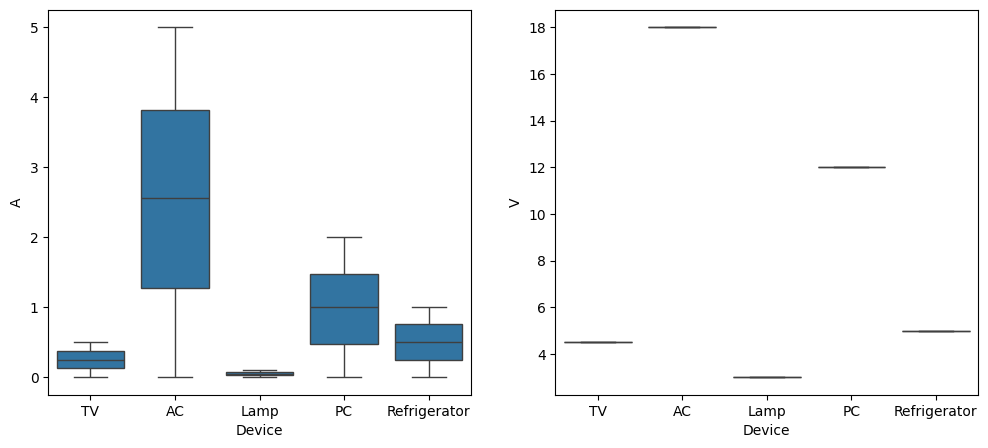

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(data=df, x='Device', y='A', ax=axs[0])
sns.boxplot(data=df, x='Device', y='V', ax=axs[1])

plt.show()


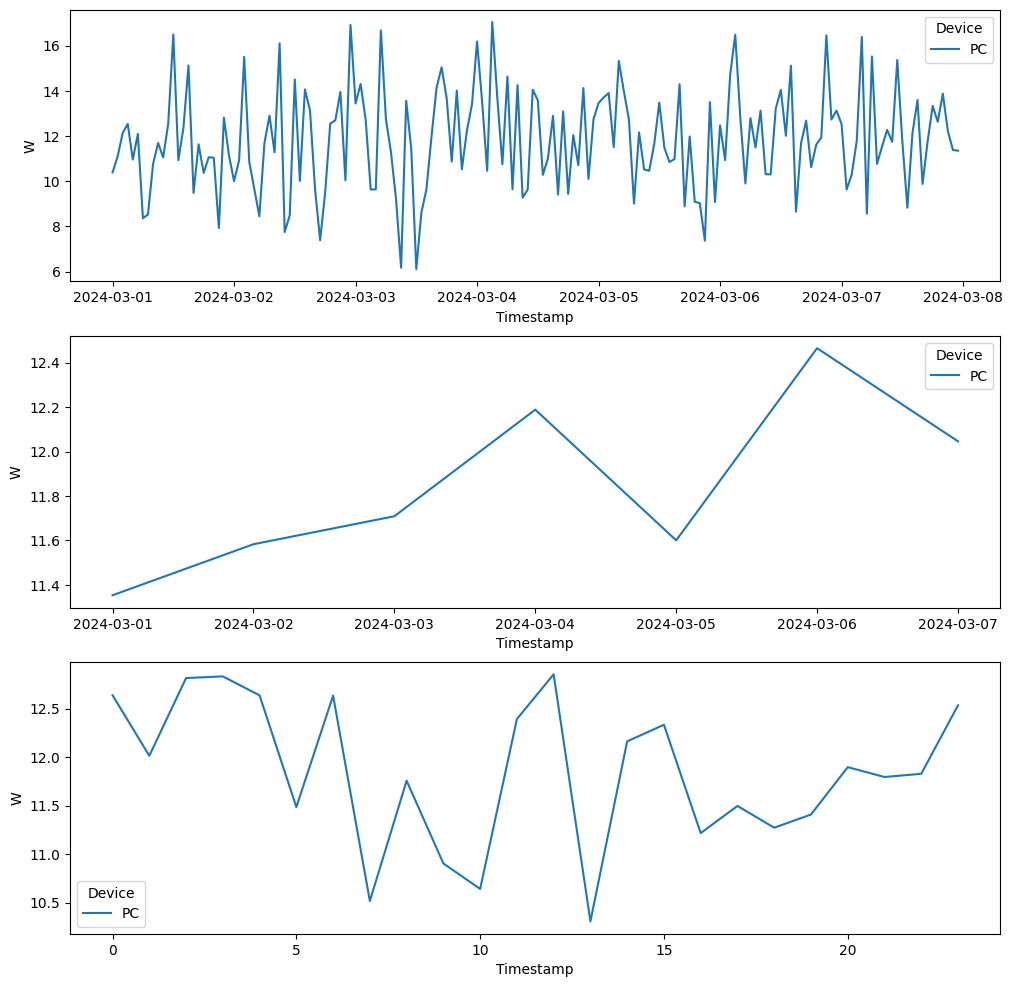

In [74]:
device = 'PC'

fig, axs = plt.subplots(3, 1, figsize=(12, 12))

df_running_hour_consumption = df.groupby(['Device', pd.Grouper(key='Timestamp', freq='1h')]).agg({'V': 'mean',
                                                                                            'A': 'sum',
                                                                                            'W': 'mean'})

df_running_hour_consumption.reset_index(inplace=True)

df_daily_consumtion = df.groupby(['Device', pd.Grouper(key='Timestamp', freq='1D')]).agg({'V': 'mean',
                                                                                            'A': 'sum',
                                                                                            'W': 'mean'})

df_daily_consumtion.reset_index(inplace=True)

df_hourly_consumption = df.groupby(['Device', df['Timestamp'].dt.hour]).agg({'V': 'mean',
                                                                                            'A': 'sum',
                                                                                            'W': 'mean'})

df_hourly_consumption.reset_index(inplace=True)

sns.lineplot(data=df_running_hour_consumption[df_running_hour_consumption['Device'] == device], hue='Device', x='Timestamp', y='W', ax=axs[0])
sns.lineplot(data=df_daily_consumtion[df_daily_consumtion['Device'] == device], hue='Device', x='Timestamp', y='W', ax=axs[1])
sns.lineplot(data=df_hourly_consumption[df_hourly_consumption['Device'] == device], hue='Device', x='Timestamp', y='W', ax=axs[2])

plt.show()